In [4]:
#1
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error
from sksurv.linear_model import CoxPHSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
import matplotlib.pyplot as plt
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.functions import StepFunction
import pickle


In [5]:
#2
# Load data
data = pd.read_csv("data/Recurrence free survival in breast cancer patients.csv")

# Define continuous and categorical variables
CONTINUOUS = ["age", "size", "nodes", "prog", "oest"]
CATEGORICAL = ["treat", "men", "grade"]

# One-hot encode categorical vars
data = pd.get_dummies(data, columns=CATEGORICAL, drop_first=True)

# Scale continuous features
# scaler = StandardScaler()
# data[CONTINUOUS] = scaler.fit_transform(data[CONTINUOUS])


In [6]:
#3
# Reset row order
data = data.sort_values("status").reset_index(drop=True)

# Select last 100 uncensored rows for test set
uncensored = data[data["status"] == 1]
DatTesting = uncensored.iloc[-75:]
DatTraining = data.drop(DatTesting.index)  # include both censored and uncensored

# Define predictors
PREDS = ["age", "size", "nodes", "prog", "oest", "treat_1", "men_2", "grade_2", "grade_3"]
X_train = DatTraining[PREDS].values
X_test = DatTesting[PREDS].values

# Format targets as structured arrays
y_train = np.array([(bool(e), float(t)) for e, t in zip(DatTraining["status"], DatTraining["time"])],
                   dtype=[("event", "bool"), ("time", "float64")])
y_test = np.array([(bool(e), float(t)) for e, t in zip(DatTesting["status"], DatTesting["time"])],
                  dtype=[("event", "bool"), ("time", "float64")])


In [7]:
#4
# Fit Cox Proportional Hazards model
coxph = CoxPHSurvivalAnalysis()
coxph.fit(X_train, y_train)

# Save the trained model to file
with open("coxph_model.pkl", "wb") as f:
    pickle.dump(coxph, f)


In [8]:
def find_nearest_arg(array, value):
    # Find the index of the nearest element of the array to the given value
    idx = (np.abs(array - value)).argmin()
    return idx

Survivors = coxph.predict_survival_function(X_test, return_array=True)

MedianTimeTraining = []

for s in Survivors:
    MedianTimeTraining.append(coxph.unique_times_[find_nearest_arg(s, 0.5)])

#DatTraining["PredictedTime"] = MedianTimeTraining

In [9]:
root_mean_squared_error(y_test["time"],MedianTimeTraining)

1162.540602875157

In [20]:
y_test["time"]

array([ 563.,  308.,  687.,  455.,  624.,  410.,  650.,  747.,  540.,
        964.,  498., 1679.,  545.,  177.,  542., 1481.,  745., 1157.,
        535.,  490.,  790.,  554.,  861.,  370., 1093.,  238.,  446.,
       1150.,  722.,  836., 1463., 1589.,  500., 1806., 1192., 1059.,
       1280.,  819.,  754.,  675.,  891.,  272.,  515.,  529.,  564.,
       1587.,  552.,  893., 2093.,  883.,  371., 1146.,  727.,  426.,
        550.,  227.,  548., 1105.,  799., 1140.,  436.,   72.,  491.,
        375.,  632.,  223.,  859.,  776.,  714.,  233.,  573., 1601.,
        956., 1918., 1701.])

In [10]:
#5
# Predict survival functions
from sksurv.nonparametric import kaplan_meier_estimator
from sksurv.functions import StepFunction

# Predict median survival from risk scores
def predict_median_survival(model, X, y):
    risk_scores = model.predict(X)
    sorted_idx = np.argsort(-risk_scores)
    durations = y["time"][sorted_idx]
    events = y["event"][sorted_idx]

    # Generate step function from sorted durations
    km_times, km_surv = kaplan_meier_estimator(events, durations)
    sf = StepFunction(km_times, km_surv)

    # Predict medians using step function
    medians = []
    for score in model.predict(X):
        # Assumption: higher risk = shorter survival
        s = StepFunction(km_times, np.power(km_surv, np.exp(score)))
        below_half = s(sf.x) < 0.5
        if np.any(below_half):
            median_idx = np.argmax(below_half)
            medians.append(sf.x[median_idx])
        else:
            medians.append(np.nan)
    return np.array(medians)

# --- Test set ---
c_index_test = concordance_index_censored(y_test["event"], y_test["time"], coxph.predict(X_test))[0]
print(f"C-index (Test): {c_index_test:.4f}")

med_test = predict_median_survival(coxph, X_test, y_test)
valid_test = ~np.isnan(med_test)


C-index (Test): 0.5942


In [11]:
model = coxph
X = X_test
y = y_test

risk_scores = model.predict(X)
sorted_idx = np.argsort(-risk_scores)
durations = y["time"][sorted_idx]
events = y["event"][sorted_idx]

# Generate step function from sorted durations
km_times, km_surv = kaplan_meier_estimator(events, durations)
sf = StepFunction(km_times, km_surv)



In [12]:
sf

StepFunction(x=array([  72.,  177.,  223.,  227.,  233.,  238.,  272.,  308.,  370.,
        371.,  375.,  410.,  426.,  436.,  446.,  455.,  490.,  491.,
        498.,  500.,  515.,  529.,  535.,  540.,  542.,  545.,  548.,
        550.,  552.,  554.,  563.,  564.,  573.,  624.,  632.,  650.,
        675.,  687.,  714.,  722.,  727.,  745.,  747.,  754.,  776.,
        790.,  799.,  819.,  836.,  859.,  861.,  883.,  891.,  893.,
        956.,  964., 1059., 1093., 1105., 1140., 1146., 1150., 1157.,
       1192., 1280., 1463., 1481., 1587., 1589., 1601., 1679., 1701.,
       1806., 1918., 2093.]), y=array([0.98666667, 0.97333333, 0.96      , 0.94666667, 0.93333333,
       0.92      , 0.90666667, 0.89333333, 0.88      , 0.86666667,
       0.85333333, 0.84      , 0.82666667, 0.81333333, 0.8       ,
       0.78666667, 0.77333333, 0.76      , 0.74666667, 0.73333333,
       0.72      , 0.70666667, 0.69333333, 0.68      , 0.66666667,
       0.65333333, 0.64      , 0.62666667, 0.61333333, 0.6

In [13]:
# Predict medians using step function
medians = []
for score in model.predict(X):
    # Assumption: higher risk = shorter survival
    s = StepFunction(km_times, np.power(km_surv, np.exp(score)))
    below_half = s(sf.x) < 0.5
    if np.any(below_half):
        median_idx = np.argmax(below_half)
        medians.append(sf.x[median_idx])
    else:
        medians.append(np.nan)

In [14]:
med_test

array([515., 500., 515., 446., 371., 515., 490., 436., 632., 632., 545.,
       650., 542., 550., 650., 650., 436., 540., 490., 490., 515., 554.,
       564., 490., 542., 545., 490., 632., 540., 548., 573., 535., 491.,
       535., 540., 563., 573., 515., 446., 573., 529., 410., 233., 542.,
       687., 500., 545., 548., 573., 426., 545., 727., 529., 550., 500.,
       498., 552., 529., 790., 529., 515., 535., 650., 490., 548., 542.,
       426., 426., 573., 455., 624., 540., 564., 632., 500.])

In [15]:
root_mean_squared_error(y_test["time"], med_test)

501.2878215157436

In [16]:
med_test[valid_test]

array([515., 500., 515., 446., 371., 515., 490., 436., 632., 632., 545.,
       650., 542., 550., 650., 650., 436., 540., 490., 490., 515., 554.,
       564., 490., 542., 545., 490., 632., 540., 548., 573., 535., 491.,
       535., 540., 563., 573., 515., 446., 573., 529., 410., 233., 542.,
       687., 500., 545., 548., 573., 426., 545., 727., 529., 550., 500.,
       498., 552., 529., 790., 529., 515., 535., 650., 490., 548., 542.,
       426., 426., 573., 455., 624., 540., 564., 632., 500.])

In [17]:
if valid_test.sum() > 0:
    rmse_test = root_mean_squared_error(y_test["time"][valid_test], med_test[valid_test])
    print(f"RMSE (Test): {rmse_test:.4f}")
else:
    print("⚠️ No valid median predictions (Test)")

# --- Train set ---
c_index_train = concordance_index_censored(y_train["event"], y_train["time"], coxph.predict(X_train))[0]
print(f"\nC-index (Train): {c_index_train:.4f}")

med_train = predict_median_survival(coxph, X_train, y_train)
valid_train = ~np.isnan(med_train)
if valid_train.sum() > 0:
    rmse_train = root_mean_squared_error(y_train["time"][valid_train], med_train[valid_train])
    print(f"RMSE (Train): {rmse_train:.4f}")
else:
    print("⚠️ No valid median predictions (Train)")


RMSE (Test): 501.2878

C-index (Train): 0.6941
RMSE (Train): 748.6095


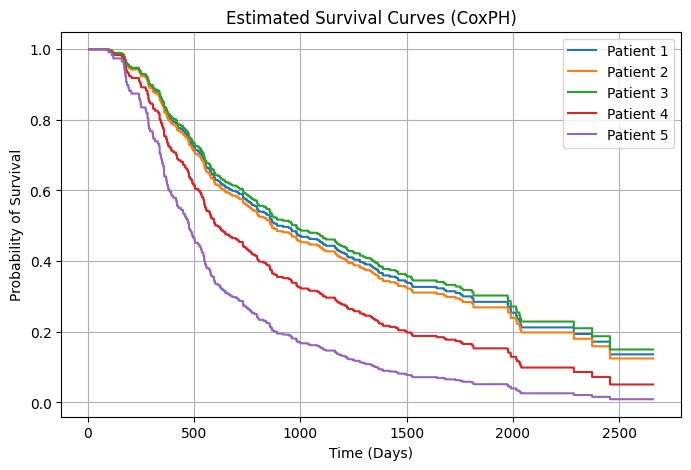

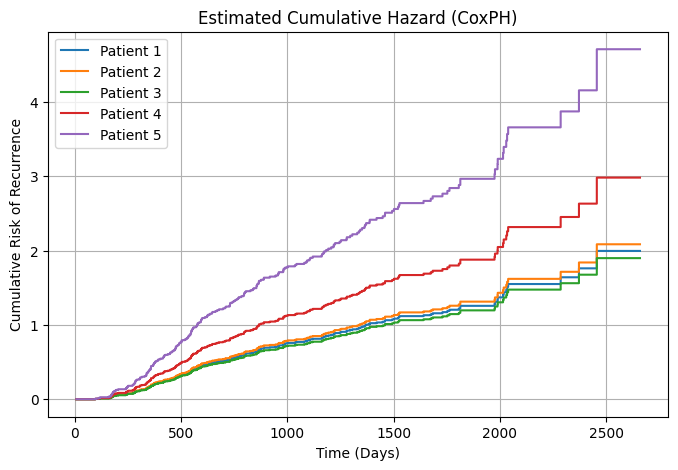

In [18]:


# Get a few test patients
X_test_sel = X_test[:5]
y_test_sel = y_test[:5]
risk_scores = coxph.predict(X_test_sel)

# --- A. Estimated Survival Curves ---
plt.figure(figsize=(8, 5))
for i, (x, score) in enumerate(zip(X_test_sel, risk_scores)):
    km_times, km_surv = kaplan_meier_estimator(y_train["event"], y_train["time"])
    s_func = StepFunction(km_times, np.power(km_surv, np.exp(score)))
    plt.step(km_times, s_func(km_times), where="post", label=f"Patient {i+1}")

plt.title("Estimated Survival Curves (CoxPH)")
plt.xlabel("Time (Days)")
plt.ylabel("Probability of Survival")
plt.grid(True)
plt.legend()
plt.show()

# --- B. Cumulative Hazard Curves (from survival) ---
plt.figure(figsize=(8, 5))
for i, (x, score) in enumerate(zip(X_test_sel, risk_scores)):
    cumhaz = -np.log(np.clip(np.power(km_surv, np.exp(score)), 1e-6, 1.0))
    plt.step(km_times, cumhaz, where="post", label=f"Patient {i+1}")

plt.title("Estimated Cumulative Hazard (CoxPH)")
plt.xlabel("Time (Days)")
plt.ylabel("Cumulative Risk of Recurrence")
plt.grid(True)
plt.legend()
plt.show()


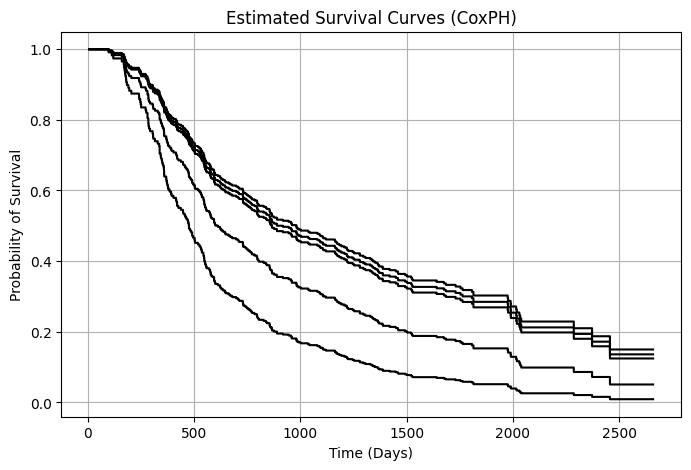

In [19]:
# --- A. Estimated Survival Curves (Black lines, no legend) ---
plt.figure(figsize=(8, 5))
for i, (x, score) in enumerate(zip(X_test_sel, risk_scores)):
    km_times, km_surv = kaplan_meier_estimator(y_train["event"], y_train["time"])
    s_func = StepFunction(km_times, np.power(km_surv, np.exp(score)))
    plt.step(km_times, s_func(km_times), where="post", color="black")

plt.title("Estimated Survival Curves (CoxPH)")
plt.xlabel("Time (Days)")
plt.ylabel("Probability of Survival")
plt.grid(True)
plt.show()
